In [1]:
import sys
sys.path.append("/home/vblot/multiaccurate_cp/")

In [2]:
import os
import yaml

import cv2
import numpy as np
import matplotlib.pyplot as plt
from mapie.multi_label_classification import MapieMultiLabelClassifier
from scipy import integrate
from scipy.optimize import minimize
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm

from multiaccurate_cp.utils.multiaccurate import J, J_prime

%load_ext autoreload
%autoreload 2

In [3]:
BASE_DIR = "/home/vblot/multiaccurate_cp/data/fire"


In [4]:
IMG_SIZE = 64
RESNET_EMBEDDING_SIZE = 256


In [6]:
DIR_CAL_PRED_PROBAS = os.path.join(BASE_DIR, "04_predictions/cal/pred_probas")
DIR_CAL_LABELS = os.path.join(BASE_DIR, "02_prepared_data/cal/labels")
DIR_TEST_PRED_PROBAS = DIR_CAL_PRED_PROBAS.replace("cal", "test")
DIR_TEST_LABELS = DIR_CAL_LABELS.replace("cal", "test")

DIR_CAL_RES_EMB = os.path.join(BASE_DIR, "04_predictions/cal/embeddings")
DIR_TEST_RES_EMB = DIR_CAL_RES_EMB.replace("cal", "test")




In [7]:
def load_data(pred_probas_dir, res_emb_dir, labels_dir):
    pred_probas = np.zeros((len(os.listdir(pred_probas_dir)), IMG_SIZE, IMG_SIZE))
    res_emb = np.zeros((len(os.listdir(res_emb_dir)), RESNET_EMBEDDING_SIZE))
    labels = np.zeros((len(os.listdir(labels_dir)), IMG_SIZE, IMG_SIZE))

    for i, (pred_proba_file, res_emb_file, label_file) in enumerate(
        tqdm(zip(
            sorted(os.listdir(pred_probas_dir)),
            sorted(os.listdir(res_emb_dir)),
            sorted(os.listdir(labels_dir))
        ))
    ):
        pred_proba = np.load(os.path.join(pred_probas_dir, pred_proba_file))
        pred_probas[i] = cv2.resize(pred_proba, (IMG_SIZE, IMG_SIZE))
        res_emb[i] = np.load(os.path.join(res_emb_dir, res_emb_file))
        label = cv2.imread(os.path.join(labels_dir, label_file), cv2.IMREAD_GRAYSCALE) / 255
        labels[i] = cv2.resize(label, (IMG_SIZE, IMG_SIZE)) > .5    
    return pred_probas, res_emb, labels


In [8]:
load_cal_pred_probas, load_cal_res_emb, load_cal_labels = load_data(
    DIR_CAL_PRED_PROBAS, DIR_CAL_RES_EMB, DIR_CAL_LABELS
)


3432it [00:03, 1038.14it/s]


In [9]:
load_test_pred_probas, load_test_res_emb, load_test_labels = load_data(
    DIR_TEST_PRED_PROBAS, DIR_TEST_RES_EMB, DIR_TEST_LABELS
)

6865it [00:06, 1097.17it/s]


In [10]:
all_pred_probas = np.concatenate([load_cal_pred_probas, load_test_pred_probas])
all_res_emb = np.concatenate([load_cal_res_emb, load_test_res_emb])
all_labels = np.concatenate([load_cal_labels, load_test_labels])


In [11]:
len(load_cal_pred_probas)

3432

In [12]:
ALPHA = .1
REGULARIZATION = None

In [13]:
class MapieWrapper():
    def __init__(self):
        self.trained_ = True
        self.classes_ = 1

    def fit(self, X, y=None):
        pass

    def predict_proba(self, X):
        return X

    def predict(self, X):
        pred_proba = self.predict_proba(X)
        return pred_proba >= .5

    def __sklearn_is_fitted__(self):
        return True

In [14]:
def grid_search_lambda(labels, pred_probas, embeddings, embedding_size):
    lambdas = [0.001, 0.01, 0.1, 0.2, 0.5, 0.7, 1]
    best_dist = np.inf
    best_lambda = None
    cv = len(lambdas)
    # get cv indices
    indices = np.arange(len(labels))
    np.random.shuffle(indices)
    indices = np.array_split(indices, cv)
    for i, lambda_ in enumerate(tqdm(lambdas)):
        test_labels = labels[indices[i]]
        test_pred_probas = pred_probas[indices[i]]
        test_res_emb = embeddings[indices[i]]
        cal_labels = np.concatenate([labels[indices[j]] for j in range(cv) if j != i])
        cal_pred_probas = np.concatenate([pred_probas[indices[j]] for j in range(cv) if j != i])
        cal_res_emb = np.concatenate([embeddings[indices[j]] for j in range(cv) if j != i])
        
        result = minimize(
            J, np.random.uniform(0, 1, embedding_size),
            method="SLSQP",
            args=(cal_labels, cal_pred_probas, cal_res_emb, ALPHA, len(cal_labels), REGULARIZATION, lambda_), jac=J_prime,
            options={"disp": False, "maxiter": 10000}
        )
        ths = np.maximum((test_res_emb @ result.x).reshape(-1, 1, 1), 0.01)
        ths = (test_res_emb @ result.x).reshape(-1, 1, 1)
        test_res_emb.shape
        y_pred_test_th = (test_pred_probas >= ths).astype(int)
        recall_test = np.nanmean((y_pred_test_th * test_labels).sum(axis=1) / test_labels.sum(axis=1))
        if (np.abs(recall_test - (1 - ALPHA))) < best_dist:
            best_dist = np.abs(recall_test - (1 - ALPHA))
            best_lambda = lambda_
        
    return best_lambda, best_dist
        

# Cross validation

In [16]:
recalls_crc = []
recalls_resnet = []

precisions_crc = []
precisions_resnet = []

for _ in tqdm(range(100)):
    cal_inx = np.random.choice(range(len(all_pred_probas)), len(all_pred_probas) // 2 , replace=False)
    test_inx = np.array([i for i in range(len(all_pred_probas)) if i not in cal_inx])
    temp_cal_pred_probas = all_pred_probas[cal_inx]
    temp_cal_res_emb = all_res_emb[cal_inx]
    temp_cal_labels = all_labels[cal_inx]

    index_not_empy = np.where(temp_cal_labels.sum(axis=(1, 2)) > 0)[0]
    temp_cal_labels = temp_cal_labels[index_not_empy]
    temp_cal_res_emb = temp_cal_res_emb[index_not_empy]
    temp_cal_pred_probas = temp_cal_pred_probas[index_not_empy]

    temp_test_pred_probas = all_pred_probas[test_inx]
    temp_test_res_emb = all_res_emb[test_inx]
    temp_test_labels = all_labels[test_inx]

    # mean_emb_cal = np.mean(temp_cal_res_emb, axis=0)
    # std_emb_cal = np.std(temp_cal_res_emb, axis=0)

    # temp_cal_res_emb = (temp_cal_res_emb - mean_emb_cal) / std_emb_cal
    # temp_test_res_emb = (temp_test_res_emb - mean_emb_cal) / std_emb_cal

    
    # pca = PCA(n_components=.85)
    # temp_cal_res_pca = pca.fit_transform(temp_cal_res_emb)
    # temp_test_res_pca = pca.transform(temp_test_res_emb)
    # N_COMP = pca.n_components_
    # scaler = MinMaxScaler()
    # temp_cal_res_pca = scaler.fit_transform(temp_cal_res_pca)
    # scaler = MinMaxScaler()
    # temp_test_res_pca = scaler.fit_transform(temp_test_res_pca)

    # CRC
    mapie_crc = MapieMultiLabelClassifier(MapieWrapper(), method="crc")
    for i in tqdm(range(len(temp_cal_pred_probas))):
        X, y = temp_cal_pred_probas[i], temp_cal_labels[i]
        mapie_crc.partial_fit(X.ravel()[np.newaxis, :], y.ravel()[np.newaxis, :])
    _, _ = mapie_crc.predict(temp_test_pred_probas.ravel()[np.newaxis, :], alpha=ALPHA)
    th_crc = mapie_crc.lambdas_star

    # ResNet
    # lambda_resnet, dist_resnet = grid_search_lambda(temp_cal_labels, temp_cal_pred_probas, temp_cal_res_emb, RESNET_EMBEDDING_SIZE)
    # print(lambda_resnet, dist_resnet)
    lambda_resnet = None
    
    result_res = minimize(
        J, np.random.uniform(0, 1, RESNET_EMBEDDING_SIZE),
        method="SLSQP",
        args=(temp_cal_labels, temp_cal_pred_probas, temp_cal_res_emb, ALPHA, len(temp_cal_labels), REGULARIZATION, lambda_resnet), jac=J_prime,
        options={"disp": True, "maxiter": 1000}, tol=1e-10
    )
    ths_res = (temp_test_res_emb @ result_res.x).reshape(-1, 1, 1)

    

    y_pred_test_th_crc = (temp_test_pred_probas >= th_crc).astype(int)
    y_pred_test_th_res = (temp_test_pred_probas >= ths_res).astype(int)

    recalls_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=(1, 2)) / temp_test_labels.sum(axis=(1, 2))))
    recalls_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=(1, 2)) / temp_test_labels.sum(axis=(1, 2))))

    precisions_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=(1, 2)) / y_pred_test_th_crc.sum(axis=(1, 2))))
    precisions_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=(1, 2)) / y_pred_test_th_res.sum(axis=(1, 2))))
    print(f"recalls: CRC = {recalls_crc[-1]}, MACP = {recalls_resnet[-1]}")
    print(f"precisions: CRC = {precisions_crc[-1]}, MACP = {precisions_resnet[-1]}")
    

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 5145/5145 [00:26<00:00, 194.60it/s]


Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.985000811882541
            Iterations: 69
            Function evaluations: 106
            Gradient evaluations: 69


/tmp/ipykernel_856564/4043767731.py:65: RuntimeWarning: invalid value encountered in divide
  recalls_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=(1, 2)) / temp_test_labels.sum(axis=(1, 2))))
/tmp/ipykernel_856564/4043767731.py:66: RuntimeWarning: invalid value encountered in divide
  recalls_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=(1, 2)) / temp_test_labels.sum(axis=(1, 2))))
/tmp/ipykernel_856564/4043767731.py:68: RuntimeWarning: invalid value encountered in divide
  precisions_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=(1, 2)) / y_pred_test_th_crc.sum(axis=(1, 2))))
/tmp/ipykernel_856564/4043767731.py:69: RuntimeWarning: invalid value encountered in divide
  precisions_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=(1, 2)) / y_pred_test_th_res.sum(axis=(1, 2))))
  1%|          | 1/100 [08:58<14:48:06, 538.24s/it]

recalls: CRC = 0.9009183028468657, MACP = 0.9050455366149459
precisions: CRC = 0.36284636350917016, MACP = 0.35787265509913113


100%|██████████| 5143/5143 [00:28<00:00, 178.32it/s]


Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.985121656021134
            Iterations: 62
            Function evaluations: 96
            Gradient evaluations: 62


/tmp/ipykernel_856564/4043767731.py:65: RuntimeWarning: invalid value encountered in divide
  recalls_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=(1, 2)) / temp_test_labels.sum(axis=(1, 2))))
/tmp/ipykernel_856564/4043767731.py:66: RuntimeWarning: invalid value encountered in divide
  recalls_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=(1, 2)) / temp_test_labels.sum(axis=(1, 2))))
/tmp/ipykernel_856564/4043767731.py:68: RuntimeWarning: invalid value encountered in divide
  precisions_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=(1, 2)) / y_pred_test_th_crc.sum(axis=(1, 2))))
/tmp/ipykernel_856564/4043767731.py:69: RuntimeWarning: invalid value encountered in divide
  precisions_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=(1, 2)) / y_pred_test_th_res.sum(axis=(1, 2))))
  2%|▏         | 2/100 [17:52<14:34:51, 535.62s/it]

recalls: CRC = 0.9005983228245289, MACP = 0.9053926994748103
precisions: CRC = 0.3626854269908182, MACP = 0.35674432513454696


100%|██████████| 5145/5145 [00:31<00:00, 164.67it/s]


# Plot results

Text(0.5, 0, 'Precision')

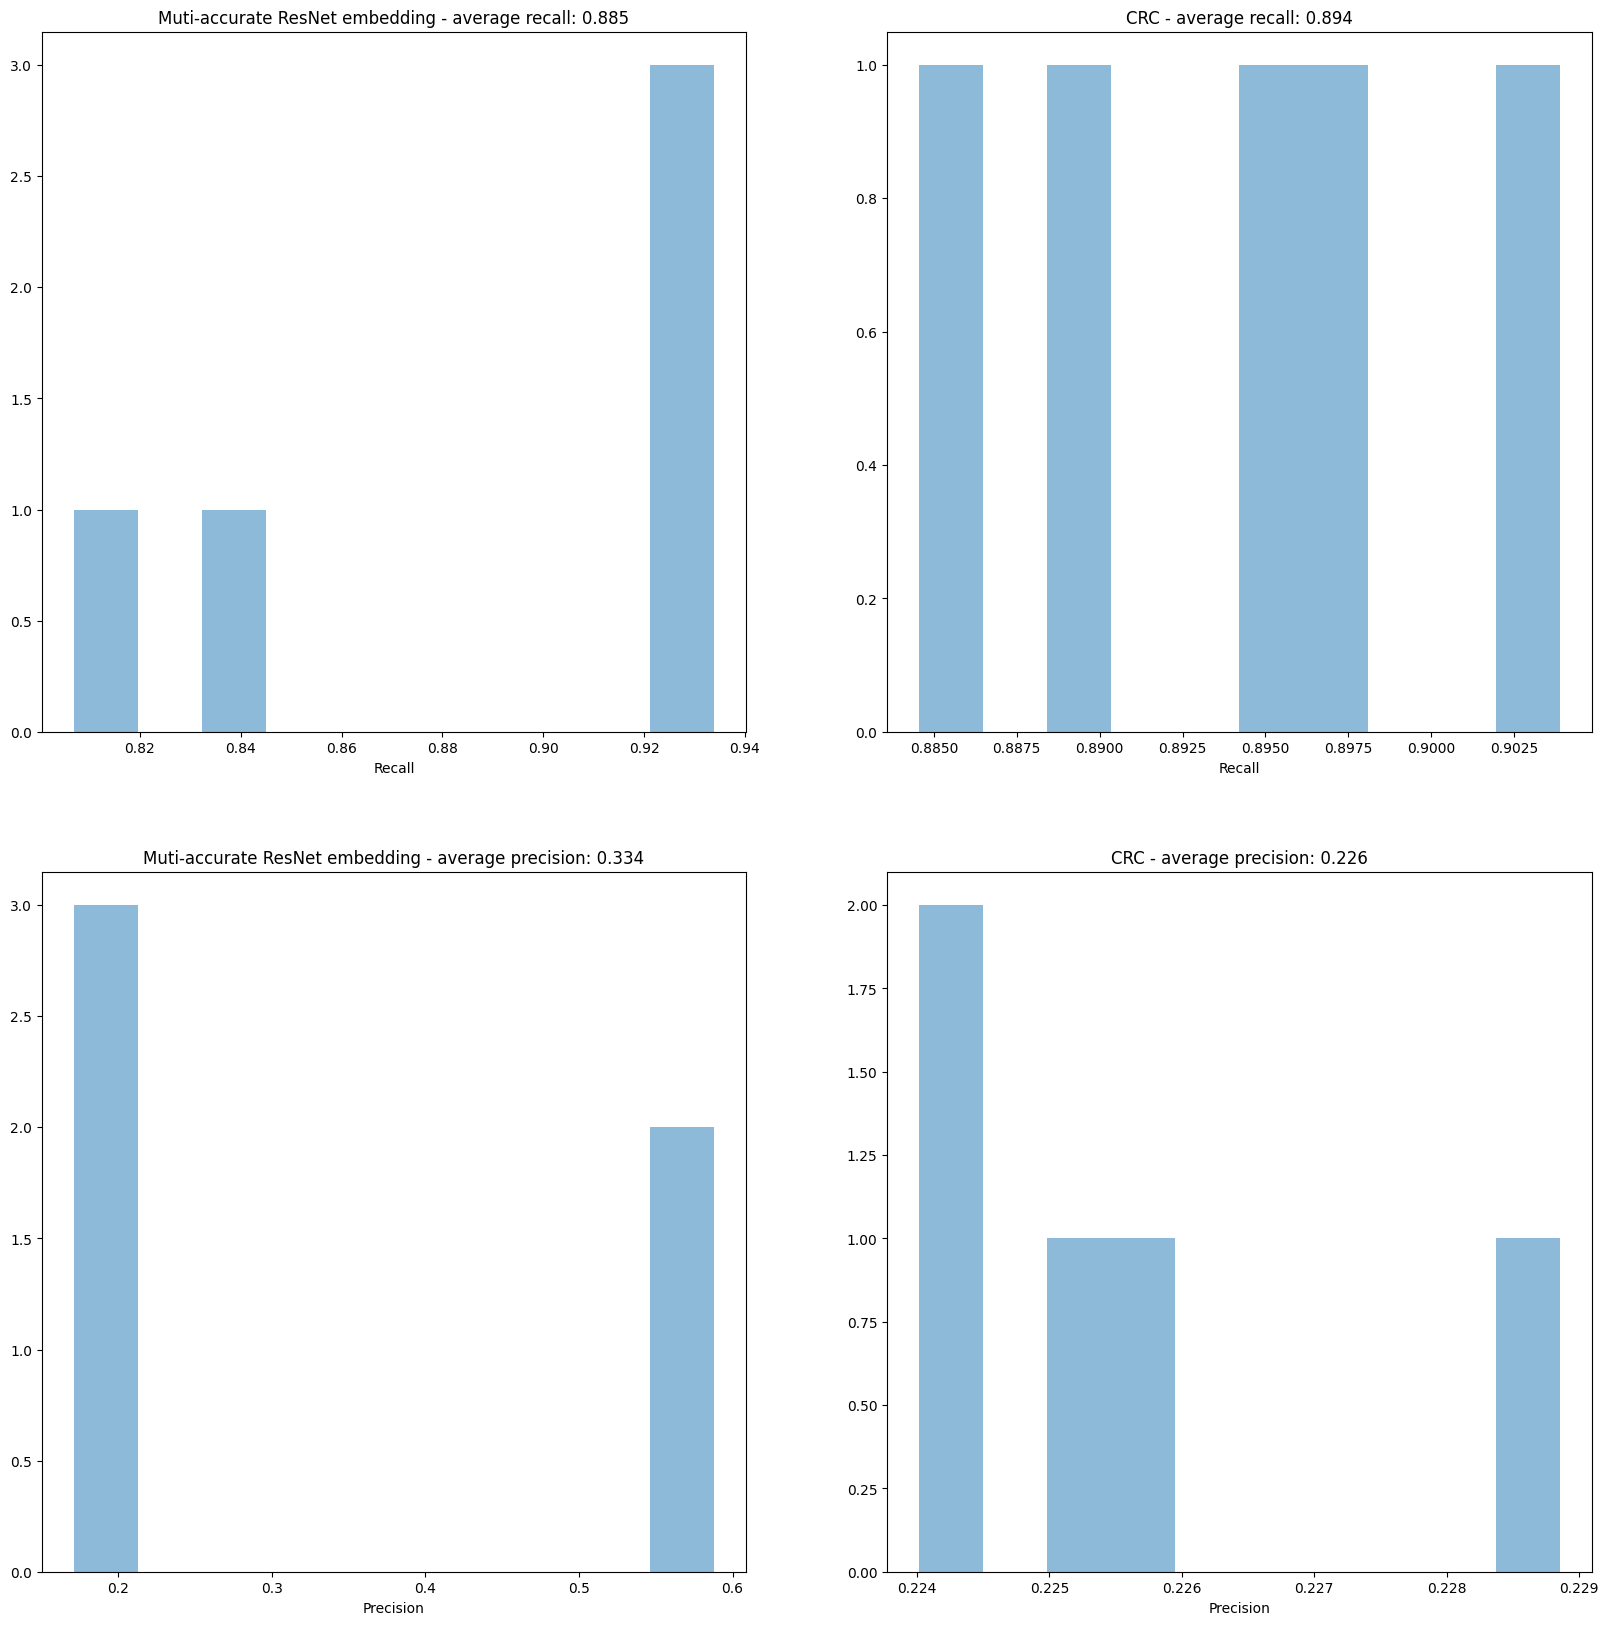

In [ ]:
s = 10
nrow = 2
ncol = 2
f, ax = plt.subplots(nrow, ncol, figsize=(ncol * s, nrow * s))


ax[0, 0].hist(recalls_resnet, bins=10, alpha=.5)
ax[0, 0].set_title(f"Muti-accurate ResNet embedding - average recall: {np.nanmean(recalls_resnet):.3f}")
ax[0, 0].set_xlabel("Recall")

ax[0, 1].hist(recalls_crc, bins=10, alpha=.5)
ax[0, 1].set_title(f"CRC - average recall: {np.nanmean(recalls_crc):.3f}")
ax[0, 1].set_xlabel("Recall")

ax[1, 0].hist(precisions_resnet, bins=10, alpha=.5)
ax[1, 0].set_title(f"Muti-accurate ResNet embedding - average precision: {np.nanmean(precisions_resnet):.3f}")
ax[1, 0].set_xlabel("Precision")

ax[1, 1].hist(precisions_crc, bins=10, alpha=.5)
ax[1, 1].set_title(f"CRC - average precision: {np.nanmean(precisions_crc):.3f}")
ax[1, 1].set_xlabel("Precision")